   gas_type  true_concentration    sensor_1  sensor_2  sensor_3  sensor_4  \
0       5.0               100.0  11977.0371  2.946364  2.490357  3.283046   
1       4.0               100.0  21234.2896  4.223873  4.758852  6.588781   
2       5.0               100.0  13190.5258  3.139281  2.743704  3.603623   
3       4.0               100.0  15803.7851  3.500589  3.375378  4.549901   
4       5.0               100.0  16342.6787  3.497127  3.393961  4.303557   

    sensor_5  sensor_6  sensor_7   sensor_8  ...  sensor_119  sensor_120  \
0   8.131875 -1.657614 -2.670484 -11.795855  ...   -2.423573   -7.170650   
1  10.873780 -3.145160 -4.474324 -14.394855  ...   -7.378631  -14.347134   
2   8.335304 -1.807550 -2.781656  -9.959871  ...   -2.658821   -7.089700   
3   8.983869 -2.278670 -3.915519 -11.937122  ...   -7.464786  -16.511583   
4   8.713730 -2.173565 -3.373084 -11.741132  ...   -2.437892   -6.492106   

   sensor_121  sensor_122  sensor_123  sensor_124  sensor_125  sensor_126  \
0  

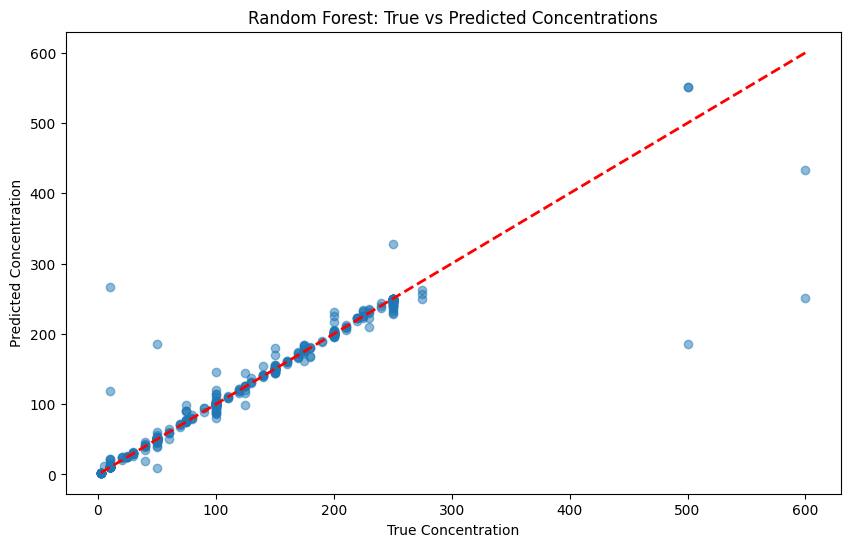

/opt/conda/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Gaussian Process Regression - Mean Squared Error: 4334.1830
Gaussian Process Regression - R-squared Score: 0.4581


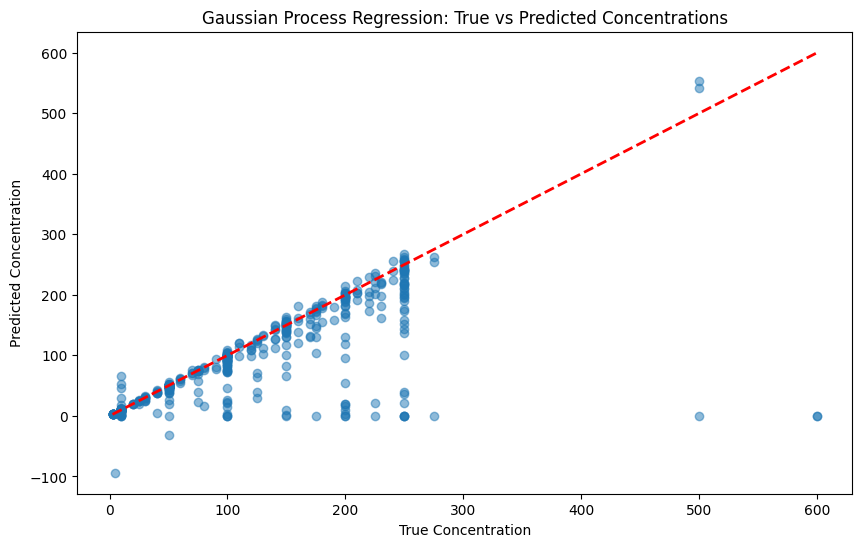

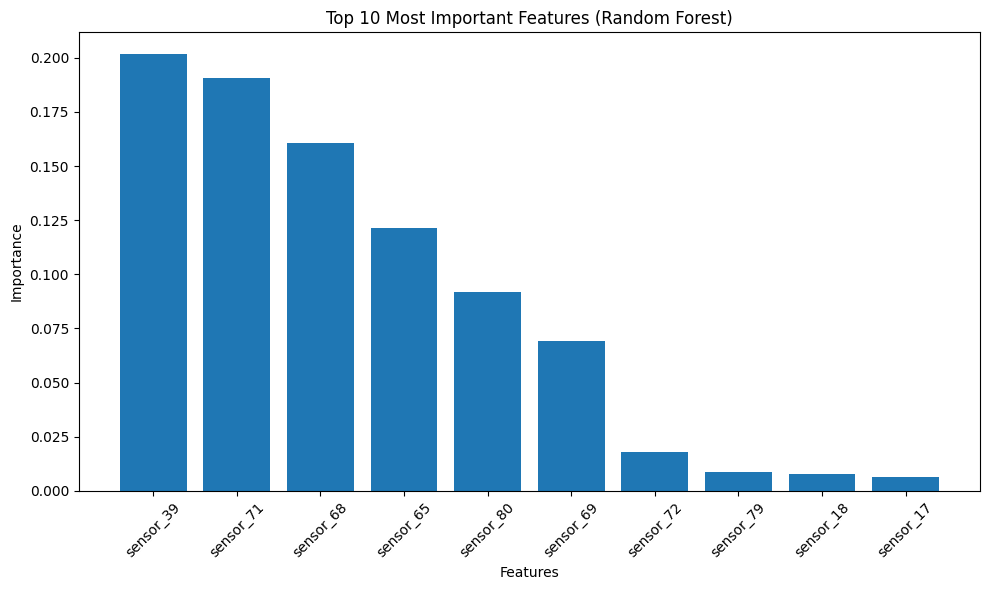

In [4]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Function to parse each line of the data
def parse_line(line):
    parts = line.strip().split()
    label, concentration = map(float, parts[0].split(';'))
    features = [float(part.split(':')[1]) for part in parts[1:]]
    return [label, concentration] + features

# Data loading and preprocessing
path = '/kaggle/input/gas-sensor-array-drift-dataset'
files = os.listdir(path)
data = []

for file in files:
    if file.endswith('.dat'):
        with open(os.path.join(path, file), 'r') as f:
            for line in f:
                data.append(parse_line(line))

# Convert to DataFrame
columns = ['gas_type', 'true_concentration'] + [f'sensor_{i}' for i in range(1, 129)]
df = pd.DataFrame(data, columns=columns)

print(df.head())

# For this example, let's focus on one gas type (you can modify this as needed)
gas_type = 1  # Change this to the gas type you want to calibrate for
df_gas = df[df['gas_type'] == gas_type]

# Splitting the Dataset
X = df_gas.iloc[:, 2:]  # Sensor readings
y = df_gas['true_concentration']  # True concentration (what we want to predict)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Function to evaluate and plot results
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"{model_name} - Mean Squared Error: {mse:.4f}")
    print(f"{model_name} - R-squared Score: {r2:.4f}")
    
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('True Concentration')
    plt.ylabel('Predicted Concentration')
    plt.title(f'{model_name}: True vs Predicted Concentrations')
    plt.show()

# Random Forest Regression
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)

evaluate_model(y_test, rf_pred, "Random Forest")

# Gaussian Process Regression
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gpr_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr_model.fit(X_train_scaled, y_train)
gpr_pred = gpr_model.predict(X_test_scaled)

evaluate_model(y_test, gpr_pred, "Gaussian Process Regression")

# Feature Importance (for Random Forest)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'][:10], feature_importance['importance'][:10])
plt.title('Top 10 Most Important Features (Random Forest)')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()